Clone Repo

In [1]:
! git clone https://github.com/mariamalaa98/skin-cancer-detection
%cd skin-cancer-detection

Cloning into 'skin-cancer-detection'...
remote: Enumerating objects: 49, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 47
Unpacking objects: 100% (49/49), done.
/content/skin-cancer-detection


In [2]:
# make directory
!mkdir dataset 
#bd5lni ll folder
%cd dataset 
!mkdir train; mkdir test

/content/skin-cancer-detection/dataset


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# hy2oli ana fin dlaw2ti
!pwd 

/content/skin-cancer-detection/dataset


Download Dataset

In [ ]:
!pwd

/content/skin-cancer-detection/dataset


In [5]:
!unzip /content/drive/MyDrive/test.zip
!unzip /content/drive/MyDrive/train.zip



Streaming output truncated to the last 5000 lines.
  inflating: train/melanoma/ISIC_0000036.jpg  
  inflating: train/melanoma/ISIC_0000040.jpg  
  inflating: train/melanoma/ISIC_0000043.jpg  
  inflating: train/melanoma/ISIC_0000046.jpg  
  inflating: train/melanoma/ISIC_0000049.jpg  
  inflating: train/melanoma/ISIC_0000054.jpg  
  inflating: train/melanoma/ISIC_0000056.jpg  
  inflating: train/melanoma/ISIC_0000074.jpg  
  inflating: train/melanoma/ISIC_0000077.jpg  
  inflating: train/melanoma/ISIC_0000078.jpg  
  inflating: train/melanoma/ISIC_0000139.jpg  
  inflating: train/melanoma/ISIC_0000140.jpg  
  inflating: train/melanoma/ISIC_0000141.jpg  
  inflating: train/melanoma/ISIC_0000142.jpg  
  inflating: train/melanoma/ISIC_0000143.jpg  
  inflating: train/melanoma/ISIC_0000145.jpg  
  inflating: train/melanoma/ISIC_0000146.jpg  
  inflating: train/melanoma/ISIC_0000147.jpg  
  inflating: train/melanoma/ISIC_0000148.jpg  
  inflating: train/melanoma/ISIC_0000149.jpg  
  inflati

In [6]:
#btwdini el mkan el ana 3wzah
# .. btrg3ni wra
%cd /content/skin-cancer-detection

/content/skin-cancer-detection


In [10]:

import sys
import time
import numpy as np
import  pandas as pd
import  torch
from torchvision import models, transforms,datasets
from torch.utils.data import DataLoader
import os
import matplotlib.pyplot as plt
from collections import Counter
from src.dataset import MelanomaDataset
from src import model_training
from src.model import SkinCancerModel
from torch.optim import Adam
from src.dataset import Normalize


In [48]:
import json
def save_dict_to_json(path_file,data_dict):
  with open(path_file, 'w') as fp:
    json.dump(data_dict, fp)
def load_dict_from_json(path_file):
  with open(path_file) as json_file:
    data = json.load(json_file)
  return data

In [9]:
backup_path="/content/drive/MyDrive/skin_cancer"

In [12]:
dataset_path="dataset"
transform=transforms.Compose([transforms.ToTensor(),Normalize()])

train=os.path.join(dataset_path,'train')
test=os.path.join(dataset_path,'test')
class_name_idx={"melanoma":1,"benign":0}
train_data=MelanomaDataset(train,class_name_idx,transform)
test_data=MelanomaDataset(test,class_name_idx,transform)

In [38]:
train_loader=DataLoader(train_data,shuffle=True,batch_size=4)
test_loader=DataLoader(test_data,shuffle=True,batch_size=1)

In [26]:
model=models.convnext_small(pretrained=True)
stop_n_layers=5

Downloading: "https://download.pytorch.org/models/convnext_small-0c510722.pth" to /root/.cache/torch/hub/checkpoints/convnext_small-0c510722.pth


  0%|          | 0.00/192M [00:00<?, ?B/s]

In [ ]:
model

In [28]:
def save_weights(model,path):
    state_dict = model.state_dict()
    torch.save(state_dict, path)

In [29]:
import torch.nn as nn

model.classifier=nn.Sequential(model.classifier[0],model.classifier[1],nn.Dropout(0.25),nn.Linear(768,1),nn.Sigmoid())


In [30]:
for i in range (stop_n_layers):
  for param in model.features[i].parameters():
    param.requires_grad=False

In [ ]:
model.load_local_weights(f"{backup_path}/weights/weights.pt")

In [31]:
model.classifier

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Dropout(p=0.25, inplace=False)
  (3): Linear(in_features=768, out_features=1, bias=True)
  (4): Sigmoid()
)

In [32]:

optimizer=Adam(model.parameters(),lr=0.001)
loss_function=torch.nn.BCELoss()

In [33]:
# train_losses=model_training.train(model,1000,train_loader,0.001,True)
torch.cuda.empty_cache()


In [34]:
!cp/content/drive/MyDrive/skin_cancer/weights

/bin/bash: cp/content/drive/MyDrive/skin_cancer/weights: No such file or directory


In [35]:
epochs=15
min_train_loss=800000
min_test_loss=800000
train_losses_list=[]
test_losses_list=[]
on_cuda=False

In [ ]:

no_batches=len(train_loader)


dataset_size=float(len(train_loader.dataset))
model.cuda()
for e in range(epochs):
  train_loss_sum=0.0
  cnt=0.0
  time_sum=0.0
  model.train()
  for img,value in train_loader:
    ts=time.time()
    optimizer.zero_grad()
    img=img.cuda()
    output=model(img)
    value=value.cuda()

    loss=loss_function(output,value)

    loss.backward()
    optimizer.step()
    current_train_loss=loss.item()*train_loader.batch_size
    train_loss_sum+=current_train_loss

    # calculate epoch info
    cnt+=1.0
    finished=int((cnt*10)/no_batches)
    remaining=10-finished
    te=time.time()
    time_sum+=(te-ts)
    avg_time=time_sum/cnt
    time_remaing=avg_time*(no_batches-cnt)
    sys.stdout.flush()
    sys.stdout.write("\r epoch "+str(e+1)+" ["+str("="*int((cnt*10)/no_batches)+str("."*remaining)+"] time remaining = "+str(time_remaing/60.0)[:8])+" train_loss="+str(current_train_loss))
    # print()

  train_loss_avg=train_loss_sum/dataset_size
  train_losses_list.append(train_loss_avg)
  





  #test


  test_loss=0.0
  model.eval()
  with torch.no_grad():
    for img ,label in test_loader:
      img=img.cuda()
      label=label.cuda()
      output=model(img)
      losses=loss_function(output,label)
      test_loss+=losses.item()*test_loader.batch_size


  test_loss/=len(test_loader.dataset)
  test_losses_list.append(test_loss)
  print()
  if train_loss_avg<min_train_loss and test_loss<min_test_loss:
    save_weights(model,"weights.pt")
    min_train_loss=train_loss_avg
    min_test_loss=test_loss
    print(f"new train loss ={train_loss_avg } new test loss= {test_loss}")

  train_dict={"train_losses":train_losses_list,"test_losses":test_losses_list}
  save_dict_to_json(backup_path+'/convnet_train_data.json',train_dict)
  
  if test_loss>train_loss_avg:
    print(" over fitting")


  print(f" epoch {e+1} train_loss ={train_loss_avg} test_loss={test_loss}")


 epoch 1 [====......] time remaining = 4.405596 train_loss=1.9388681650161743

In [ ]:
model.save_weights(f"{backup_path}/weights/weights.pt")

In [ ]:
!cp /content/skin-cancer-detection/weights.pt /content/drive/MyDrive/skin_cancer/weights/weights.pt

In [47]:
print(min_test_loss)
print(train_losses_list[-1])

0.3103467176266713
0.24479273674705176


In [41]:
count=0
loss_test=0.0
melanoma_score_sum=0.0
cnt_melanoma=0
cnt_non_melanoma=0
non_melanona_score_sum=0.0
model.eval()
with torch.no_grad():
  for img ,label in test_loader:
          img=img.cuda()
          label=label.cuda()
          result=model(img)

          if label.item()==1:
            melanoma_score_sum+=result.cpu().item()
            cnt_melanoma+=1
          else:
            non_melanona_score_sum+=result.cpu().item()
            cnt_non_melanoma+=1

          if result>0.55:
                result=1
          else:
                  result=0

          if result==label:
                  count+=1
model.train()

ConvNeXt(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
      (1): LayerNorm2d((96,), eps=1e-06, elementwise_affine=True)
    )
    (1): Sequential(
      (0): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384, bias=True)
          (4): GELU()
          (5): Linear(in_features=384, out_features=96, bias=True)
          (6): Permute()
        )
        (stochastic_depth): StochasticDepth(p=0.0, mode=row)
      )
      (1): CNBlock(
        (block): Sequential(
          (0): Conv2d(96, 96, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=96)
          (1): Permute()
          (2): LayerNorm((96,), eps=1e-06, elementwise_affine=True)
          (3): Linear(in_features=96, out_features=384

In [43]:
accuracy=(count/len(test_loader))*100
print(accuracy)
print(melanoma_score_sum/cnt_melanoma)
print(non_melanona_score_sum/cnt_non_melanoma)

83.5625
0.8277397045927541
0.24099711236286195


In [ ]:
torch.cuda.empty_cache()


In [ ]:
train_iter=iter(test_loader)

In [ ]:
model.eval()
with torch.no_grad():
  for i in range (10):
    img,label=next(train_iter)
    img,label=img.cuda(),label.cuda()
    output=model(img)
    print(f"Actual value:{label.item()}")
    print(f"Predicted value:{round(output.item(),3)}")
    

Actual value:1.0
Predicted value:0.998
Actual value:1.0
Predicted value:0.608
Actual value:1.0
Predicted value:0.998
Actual value:1.0
Predicted value:0.572
Actual value:1.0
Predicted value:0.293
Actual value:1.0
Predicted value:0.577
Actual value:1.0
Predicted value:0.666
Actual value:1.0
Predicted value:0.999
Actual value:1.0
Predicted value:0.923
Actual value:1.0
Predicted value:0.582


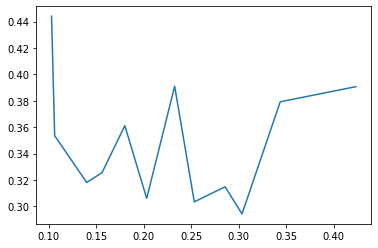

In [ ]:
plt.plot(train_losses_list,test_losses_list)

In [49]:
eff_train_test_dict=load_dict_from_json("/content/drive/MyDrive/skin_cancer/eff_train_data.json")

In [51]:
eff_train_losses,eff_test_losses=eff_train_test_dict['train_losses'],eff_train_test_dict['test_losses']

In [52]:
def plot_train_validation(*curves: tuple):
    for data, label in curves:
        plt.plot(data, label=label)
    plt.legend(frameon=False)

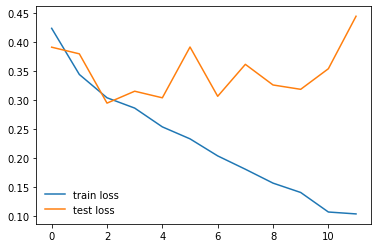

In [54]:
plot_train_validation((eff_train_losses,"train loss"),(eff_test_losses,"test loss"))

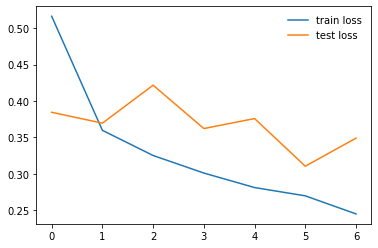

In [55]:
plot_train_validation((train_losses_list,"train loss"),(test_losses_list,"test loss"))

In [1]:
!jupyter nbconvert conv_net_skin_cancer_detection (1).ipynb --to html

This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answer_yes=True]
--execute
    Execute the notebook prior to export.
    Equivalent to: [--ExecutePr

[NbConvertApp] WARNING | pattern 'conv_net_skin_cancer_detection' matched no files
[NbConvertApp] WARNING | pattern '(1).ipynb' matched no files
